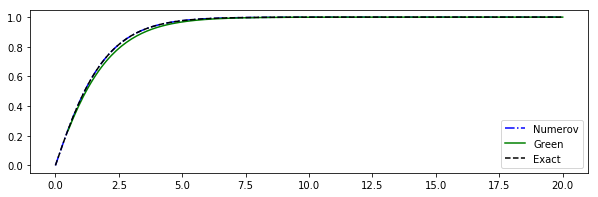

In [2]:
from __future__ import print_function
import numpy as np
#from scipy.constants import hbar
import matplotlib.pyplot as plt


def numerov(xgrid, y_0, y_1, k, S):
    """
    Numerov algorithm
   
    Solve 
   
        d^2
       ------y(x) + k(x)^2 * y(x) = S(x)
        dx^2
   
    by approximating the 2nd derivative 
    by the 3-point formula,
   
        yn+1 - 2yn + yn-1            h^2
       ------------------- = y''n + -----y''''n + O(h^4) .
               h^2                   12
   
    By some rearrangement,
   
             h^2                      5h^2               h^2
       (1 + -----kn+1^2)yn+1 - 2(1 - ------kn^2)yn + (1 + -----kn-1^2)yn-1
       
             12                        12                12
                    h^2
      = -----(Sn+1 + 10*Sn + Sn-1) + O(h^6)
         12
   
   
    *** One should know the the two initial points, k and S terms.
   
   
    - Case 1: Two initial values are given.
   
        y(0) = y0, y(1) = y1 --> y(2) is directly calculated.
   
   
    - Case 2: One initial value and its gradient is given.
   
        y(0) = y0, y'(0) = y'0 --> y(1) should be estimated by some formula.
   
        Then one can follow "Case 1".


    Inputs
    ------
    - xgrid : x (1-D array)
    
    - y_0   : y, initial condition 1
       Output
    ------
    - y : solution of the differential equation (1-D array)

    """
    # initialize y
    ngrid = len(xgrid)
    h = xgrid[1] - xgrid[0]
    y = np.zeros(ngrid)
    y[0] = y_0
    y[1] = y_1

    # main loop: evaluate y[j]
    for j in np.arange(2, ngrid):

        y1 = y[j-2]; y2 = y[j-1]
        k1 = k[j-2]; k2 = k[j-1]; k3 = k[j]
        s1 = S[j-2]; s2 = S[j-1]; s3 = S[j]

        term_S = 1/12. * h**2 * (s3 + 10*s2 + s1)
        term_3 =      (1 + 1/12. *   h**2 * k3**2)
        term_2 = -2 * (1 - 5/12. * 5*h**2 * k2**2) * y2
        term_1 =      (1 + 1/12. *   h**2 * k1**2) * y1

        y3 = (term_S - term_2 - term_1) / term_3
        y[j] = y3

    return y

def simpson_38(arr_x, arr_y, intp_mag=5):

    """
    Integration using Simpson's 3/8 rule

             |b
    Integral |  y(x) dx 
             |a

    Inputs
    ------
    - arr_x : x (1-D array), ex) numpy.linspace(a, b, 1001)
    - arr_y : y (1-D array), integrand y(x), len(arr_y)==len(arr_x)
    - intp_mag : internal interpolation (default=5 is enough in general.)

    """

    # interpolation
    arr_y = np.interp(np.linspace(arr_x[0], arr_x[-1], intp_mag*len(arr_x)), arr_x, arr_y)
    arr_x = np.linspace(arr_x[0], arr_x[-1], intp_mag*len(arr_x))

    # simpson, trapezoidal sum for the remainders
    S = 0; S_r = 0
    if len(arr_x) % 3 == 2:
        S_r = (arr_y[-2]+arr_y[-1])*(arr_x[-1]-arr_x[-2])/2.
        arr_x = arr_x[:-1]; arr_y = arr_y[:-1]
    elif len(arr_y) % 3 == 0:
        S_r = ((arr_y[-1]+arr_y[-2])*(arr_x[-1]-arr_x[-2])/2.) + \
              ((arr_y[-2]+arr_y[-3])*(arr_x[-2]-arr_x[-3])/2.)
        arr_x = arr_x[:-2]; arr_y = arr_y[:-2]
        
    # integration
    i = 0
    for x in arr_x:
        if i > len(arr_x)-2: break
        a = arr_x[i]; b = arr_x[i+3]; h = b - a
        S += (h/8)*(arr_y[i]+3*arr_y[i+1]+3*arr_y[i+2]+arr_y[i+3])
        i += 3
    return S + S_r


def phi_lt(xgrid, l):
    """
    Calculate phi_<
    """
    return xgrid**(l+1)

def phi_gt(xgrid, l):
    """
    Calculate phi_>
    """
    return (-1./(2*l+1))*(xgrid**-l)

def rho(xgrid):
    """
    Eq. (3.9)
    """
    return (1./(8.*np.pi))*np.exp(-xgrid)

def y_exact(xgrid):
    return 1 - 0.5*(xgrid+2)*np.exp(-xgrid)


# domain
xgrid = np.linspace(0., 20., 201)
ngrid = len(xgrid)

# initial values
l = 0
y_0 = 0.; y_1 = y_exact(xgrid)[1]
k = np.zeros(ngrid) # k = 0 for l = 0
S = np.zeros(ngrid); S += -4*np.pi * xgrid * rho(xgrid)

# Numerical solution 
y = numerov(xgrid, y_0, y_1, k, S)

# Direct solution from Green's function method
l = 0
k = np.zeros(ngrid) # k = 0 for l = 0
S = np.zeros(ngrid); S += -4*np.pi * xgrid * rho(xgrid)
y_lt = phi_lt(xgrid, l)
y_gt = phi_gt(xgrid, l)

y_gr = []
for j in range(5,ngrid):
  #  print (j)
    phi_1 = y_gt[j] * simpson_38(xgrid[:j], y_lt[:j]*S[:j])
    phi_2 = y_lt[j] * simpson_38(xgrid[j:], y_gt[j:]*S[j:])
    phi_x = phi_1 + phi_2
    y_gr.append(phi_x)

# Figure
fig = plt.figure(figsize=(10,3))
fig1 = fig.add_subplot(111)
fig1.plot(xgrid,     y,    'b-.', label='Numerov')
fig1.plot(xgrid[5:], y_gr, 'g-',  label='Green')
fig1.plot(xgrid, y_exact(xgrid), 'k--', label='Exact')
fig1.legend()
plt.show()
